# A szükséges könyvtárak importálása és az adatok beolvasása

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn import tree
from imblearn.over_sampling import SMOTE
from IPython.display import display

pd.options.display.max_columns = None
data = pd.read_excel('database.xlsx', header=0) 
data

,CLIENT_ID,DEFAULT,PAYMENT_DEFAULT_2Y,N_OF_APPL_ACCEPTED,DAYS_PAST_DUE,FORCED_COLL_AUTHORITY,LOAN_TYPE_CATEGORY,EBITDA,WORST_STATUS_CB,NB_LOANS_PERF,NUMBER_OF_EMPLOYEES,fix_assets_per_liab,MAX_AMT_DELAY_CB,PROFIT_AFTER_TAX,NB_OF_LOANS,receivables_per_curr_liab
0,1,0,NaN,21.0,NaN,1.0,short term loans,2481000,2.0,7.0,3.0,0.065411,0.00,231000.0,NaN,0.190007
1,2,0,1.0,19.0,NaN,1.0,short term loans,499000,7.0,2.0,7.0,0.021201,130808.84,2000.0,NaN,0.147106
2,3,0,1.0,10.0,0.0,0.0,Current account overdraft,520000,2.0,4.0,3.0,0.008924,63370.38,441000.0,2.0,0.028529
3,4,0,1.0,13.0,16.0,1.0,Current account overdraft,-1753000,2.0,3.0,3.0,0.003685,63370.38,298000.0,5.0,0.076061
4,5,0,NaN,6.0,0.0,0.0,Current account overdraft,-1774000,1.0,3.0,4.0,0.017761,0.00,270000.0,2.0,0.086796
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2032,2033,0,NaN,10.0,2.0,0.0,Card,9851000,2.0,3.0,12.0,0.478851,93220.53,5311000.0,2.0,0.950464
2033,2034,0,NaN,3.0,NaN,0.0,Current account overdraft,777000,1.0,2.0,5.0,0.055874,0.00,198000.0,NaN,0.488154
2034,2035,0,1.0,25.0,NaN,0.0,Current account overdraft,2859000,2.0,9.0,7.0,0.648101,39640.59,1641000.0,NaN,0.010896
2035,2036,0,1.0,25.0,NaN,0.0,short term loans,2859000,2.0,9.0,7.0,0.648101,39640.59,1641000.0,NaN,0.010896


In [2]:
data[data['DEFAULT'] == 1].shape[0]

58

# A LOAN_TYPE_CATEGORY változó vizsgálata
A LOAN_TYPE_CATEGORY az egyetlen kategorikus változó. Az alábbi két ábra azt mutatja, hogy a változó eloszlása nagyjából azonos a fizető és a nem fizető ügyfelekre vonatkozóan.

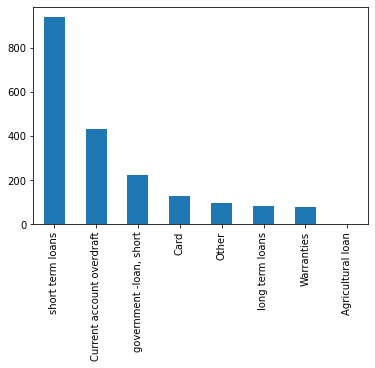

In [3]:
data[data['DEFAULT'] == 0]['LOAN_TYPE_CATEGORY'].value_counts().plot(kind='bar')

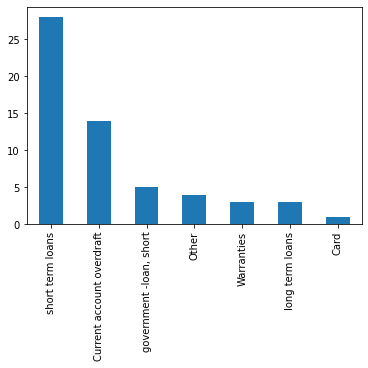

In [4]:
data[data['DEFAULT'] == 1]['LOAN_TYPE_CATEGORY'].value_counts().plot(kind='bar')

A LOAN_TYPE_CATEGORY-t dummy változókra cseréljük, ugyanis az sklearn csak numerikus változókat képes kezelni.

In [5]:
loan_type_category_dummies = pd.get_dummies(data.LOAN_TYPE_CATEGORY, prefix='LTC')
data = pd.concat([data, loan_type_category_dummies], axis=1)
data = data.drop(['LOAN_TYPE_CATEGORY'], axis=1)
data

,CLIENT_ID,DEFAULT,PAYMENT_DEFAULT_2Y,N_OF_APPL_ACCEPTED,DAYS_PAST_DUE,FORCED_COLL_AUTHORITY,EBITDA,WORST_STATUS_CB,NB_LOANS_PERF,NUMBER_OF_EMPLOYEES,fix_assets_per_liab,MAX_AMT_DELAY_CB,PROFIT_AFTER_TAX,NB_OF_LOANS,receivables_per_curr_liab,LTC_Agricultural loan,LTC_Card,LTC_Current account overdraft,LTC_Other,LTC_Warranties,"LTC_government -loan, short",LTC_long term loans,LTC_short term loans
0,1,0,NaN,21.0,NaN,1.0,2481000,2.0,7.0,3.0,0.065411,0.00,231000.0,NaN,0.190007,0,0,0,0,0,0,0,1
1,2,0,1.0,19.0,NaN,1.0,499000,7.0,2.0,7.0,0.021201,130808.84,2000.0,NaN,0.147106,0,0,0,0,0,0,0,1
2,3,0,1.0,10.0,0.0,0.0,520000,2.0,4.0,3.0,0.008924,63370.38,441000.0,2.0,0.028529,0,0,1,0,0,0,0,0
3,4,0,1.0,13.0,16.0,1.0,-1753000,2.0,3.0,3.0,0.003685,63370.38,298000.0,5.0,0.076061,0,0,1,0,0,0,0,0
4,5,0,NaN,6.0,0.0,0.0,-1774000,1.0,3.0,4.0,0.017761,0.00,270000.0,2.0,0.086796,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2032,2033,0,NaN,10.0,2.0,0.0,9851000,2.0,3.0,12.0,0.478851,93220.53,5311000.0,2.0,0.950464,0,1,0,0,0,0,0,0
2033,2034,0,NaN,3.0,NaN,0.0,777000,1.0,2.0,5.0,0.055874,0.00,198000.0,NaN,0.488154,0,0,1,0,0,0,0,0
2034,2035,0,1.0,25.0,NaN,0.0,2859000,2.0,9.0,7.0,0.648101,39640.59,1641000.0,NaN,0.010896,0,0,1,0,0,0,0,0
2035,2036,0,1.0,25.0,NaN,0.0,2859000,2.0,9.0,7.0,0.648101,39640.59,1641000.0,NaN,0.010896,0,0,0,0,0,0,0,1


# Adatok felosztása tanító- és teszthalmazra

In [6]:
train_data, test_data = train_test_split(data, random_state=1, test_size=0.2, stratify=data.DEFAULT)
train_data

,CLIENT_ID,DEFAULT,PAYMENT_DEFAULT_2Y,N_OF_APPL_ACCEPTED,DAYS_PAST_DUE,FORCED_COLL_AUTHORITY,EBITDA,WORST_STATUS_CB,NB_LOANS_PERF,NUMBER_OF_EMPLOYEES,fix_assets_per_liab,MAX_AMT_DELAY_CB,PROFIT_AFTER_TAX,NB_OF_LOANS,receivables_per_curr_liab,LTC_Agricultural loan,LTC_Card,LTC_Current account overdraft,LTC_Other,LTC_Warranties,"LTC_government -loan, short",LTC_long term loans,LTC_short term loans
1367,1368,0,NaN,NaN,0.0,0.0,233000,NaN,NaN,5.0,0.033929,NaN,0.0,2.0,0.058261,0,0,1,0,0,0,0,0
1648,1649,0,NaN,2.0,0.0,0.0,643000,1.0,1.0,4.0,0.163428,0.00,340000.0,1.0,0.257598,0,0,0,0,0,0,0,1
2031,2032,0,NaN,10.0,NaN,0.0,9851000,2.0,3.0,12.0,0.478851,93220.53,5311000.0,NaN,0.950464,0,0,0,0,0,0,0,1
1242,1243,0,NaN,NaN,NaN,0.0,12044000,NaN,NaN,NaN,0.064846,NaN,1153000.0,NaN,0.071791,0,0,0,0,0,1,0,0
1498,1499,0,NaN,16.0,0.0,0.0,1705000,2.0,6.0,5.0,0.374382,0.00,1099000.0,1.0,0.715053,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
758,759,0,1.0,71.0,NaN,0.0,56253000,2.0,17.0,25.0,1.990251,21346.03,46703000.0,NaN,0.241523,0,1,0,0,0,0,0,0
687,688,0,1.0,8.0,0.0,1.0,436000,2.0,1.0,4.0,0.007403,29941.86,274000.0,1.0,0.344248,0,0,0,0,0,0,0,1
399,400,0,NaN,0.0,0.0,1.0,362000,1.0,0.0,2.0,0.056162,0.00,264000.0,0.0,0.274961,0,0,0,0,0,0,0,1
1346,1347,0,NaN,NaN,NaN,1.0,830000,NaN,NaN,30.0,0.567422,NaN,448000.0,NaN,0.442287,0,0,0,0,0,0,0,1


In [7]:
train_data.describe()

,CLIENT_ID,DEFAULT,PAYMENT_DEFAULT_2Y,N_OF_APPL_ACCEPTED,DAYS_PAST_DUE,FORCED_COLL_AUTHORITY,EBITDA,WORST_STATUS_CB,NB_LOANS_PERF,NUMBER_OF_EMPLOYEES,fix_assets_per_liab,MAX_AMT_DELAY_CB,PROFIT_AFTER_TAX,NB_OF_LOANS,receivables_per_curr_liab,LTC_Agricultural loan,LTC_Card,LTC_Current account overdraft,LTC_Other,LTC_Warranties,"LTC_government -loan, short",LTC_long term loans,LTC_short term loans
count,1629.000000,1629.000000,260.0,1036.000000,1036.000000,1392.000000,1.629000e+03,1036.000000,1036.000000,1605.000000,1622.000000,1.036000e+03,1.622000e+03,1036.000000,1622.000000,1629.000000,1629.000000,1629.000000,1629.000000,1629.000000,1629.000000,1629.000000,1629.000000
mean,1009.379374,0.028238,1.0,10.721042,4.583012,0.312500,3.416998e+06,1.712355,2.537645,213.964486,0.330598,1.228191e+05,1.906464e+06,1.783784,0.420964,0.001228,0.064457,0.217925,0.052179,0.042971,0.106200,0.039902,0.475138
std,588.277053,0.165703,0.0,17.108869,39.158687,0.463679,1.556935e+07,0.931614,3.551081,3917.612855,0.810732,9.387515e+05,1.112663e+07,1.101412,0.527044,0.035028,0.245640,0.412963,0.222457,0.202854,0.308188,0.195789,0.499535
min,1.000000,0.000000,1.0,0.000000,0.000000,0.000000,-1.048400e+07,1.000000,0.000000,1.000000,0.000000,0.000000e+00,-1.625100e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,500.000000,0.000000,1.0,2.750000,0.000000,0.000000,2.590000e+05,1.000000,1.000000,2.000000,0.000000,0.000000e+00,1.340000e+05,1.000000,0.087685,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1010.000000,0.000000,1.0,6.000000,0.000000,0.000000,6.460000e+05,2.000000,2.000000,4.000000,0.098635,0.000000e+00,2.860000e+05,1.000000,0.271818,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1516.000000,0.000000,1.0,13.000000,0.000000,1.000000,1.944000e+06,2.000000,3.000000,10.000000,0.389528,3.776723e+04,7.412500e+05,2.000000,0.573683,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,2035.000000,1.000000,1.0,207.000000,1057.000000,1.000000,2.817260e+08,8.000000,41.000000,90119.000000,21.994444,1.916738e+07,2.360610e+08,7.000000,7.032895,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# A hiányzó adatok kezelése

In [8]:
train_data.isnull().sum()

CLIENT_ID                           0
DEFAULT                             0
PAYMENT_DEFAULT_2Y               1369
N_OF_APPL_ACCEPTED                593
DAYS_PAST_DUE                     593
FORCED_COLL_AUTHORITY             237
EBITDA                              0
WORST_STATUS_CB                   593
NB_LOANS_PERF                     593
NUMBER_OF_EMPLOYEES                24
fix_assets_per_liab                 7
MAX_AMT_DELAY_CB                  593
PROFIT_AFTER_TAX                    7
NB_OF_LOANS                       593
receivables_per_curr_liab           7
LTC_Agricultural loan               0
LTC_Card                            0
LTC_Current account overdraft       0
LTC_Other                           0
LTC_Warranties                      0
LTC_government -loan, short         0
LTC_long term loans                 0
LTC_short term loans                0
dtype: int64

Első körben a hiányzó adatokat az adott változó átlagával helyettesítjük.

In [9]:
train_data1 = train_data.copy()
test_data1 = test_data.copy()

train_data1['PAYMENT_DEFAULT_2Y'].fillna(train_data1['PAYMENT_DEFAULT_2Y'].mean(), inplace=True)
test_data1['PAYMENT_DEFAULT_2Y'].fillna(train_data1['PAYMENT_DEFAULT_2Y'].mean(), inplace=True)

train_data1['N_OF_APPL_ACCEPTED'].fillna(train_data1['N_OF_APPL_ACCEPTED'].mean(), inplace=True)
test_data1['N_OF_APPL_ACCEPTED'].fillna(train_data1['N_OF_APPL_ACCEPTED'].mean(), inplace=True)

train_data1['DAYS_PAST_DUE'].fillna(train_data1['DAYS_PAST_DUE'].mean(), inplace=True)
test_data1['DAYS_PAST_DUE'].fillna(train_data1['DAYS_PAST_DUE'].mean(), inplace=True)

train_data1['FORCED_COLL_AUTHORITY'].fillna(train_data1['FORCED_COLL_AUTHORITY'].mean(), inplace=True)
test_data1['FORCED_COLL_AUTHORITY'].fillna(train_data1['FORCED_COLL_AUTHORITY'].mean(), inplace=True)

train_data1['WORST_STATUS_CB'].fillna(train_data1['WORST_STATUS_CB'].mean(), inplace=True)
test_data1['WORST_STATUS_CB'].fillna(train_data1['WORST_STATUS_CB'].mean(), inplace=True)

train_data1['NB_LOANS_PERF'].fillna(train_data1['NB_LOANS_PERF'].mean(), inplace=True)
test_data1['NB_LOANS_PERF'].fillna(train_data1['NB_LOANS_PERF'].mean(), inplace=True)

train_data1['NUMBER_OF_EMPLOYEES'].fillna(train_data1['NUMBER_OF_EMPLOYEES'].mean(), inplace=True)
test_data1['NUMBER_OF_EMPLOYEES'].fillna(train_data1['NUMBER_OF_EMPLOYEES'].mean(), inplace=True)

train_data1['fix_assets_per_liab'].fillna(train_data1['fix_assets_per_liab'].mean(), inplace=True)
test_data1['fix_assets_per_liab'].fillna(train_data1['fix_assets_per_liab'].mean(), inplace=True)

train_data1['MAX_AMT_DELAY_CB'].fillna(train_data1['MAX_AMT_DELAY_CB'].mean(), inplace=True)
test_data1['MAX_AMT_DELAY_CB'].fillna(train_data1['MAX_AMT_DELAY_CB'].mean(), inplace=True)

train_data1['PROFIT_AFTER_TAX'].fillna(train_data1['PROFIT_AFTER_TAX'].mean(), inplace=True)
test_data1['PROFIT_AFTER_TAX'].fillna(train_data1['PROFIT_AFTER_TAX'].mean(), inplace=True)

train_data1['NB_OF_LOANS'].fillna(train_data1['NB_OF_LOANS'].mean(), inplace=True)
test_data1['NB_OF_LOANS'].fillna(train_data1['NB_OF_LOANS'].mean(), inplace=True)

train_data1['receivables_per_curr_liab'].fillna(train_data1['receivables_per_curr_liab'].mean(), inplace=True)
test_data1['receivables_per_curr_liab'].fillna(train_data1['receivables_per_curr_liab'].mean(), inplace=True)

train_data1

,CLIENT_ID,DEFAULT,PAYMENT_DEFAULT_2Y,N_OF_APPL_ACCEPTED,DAYS_PAST_DUE,FORCED_COLL_AUTHORITY,EBITDA,WORST_STATUS_CB,NB_LOANS_PERF,NUMBER_OF_EMPLOYEES,fix_assets_per_liab,MAX_AMT_DELAY_CB,PROFIT_AFTER_TAX,NB_OF_LOANS,receivables_per_curr_liab,LTC_Agricultural loan,LTC_Card,LTC_Current account overdraft,LTC_Other,LTC_Warranties,"LTC_government -loan, short",LTC_long term loans,LTC_short term loans
1367,1368,0,1.0,10.721042,0.000000,0.0,233000,1.712355,2.537645,5.000000,0.033929,122819.123176,0.0,2.000000,0.058261,0,0,1,0,0,0,0,0
1648,1649,0,1.0,2.000000,0.000000,0.0,643000,1.000000,1.000000,4.000000,0.163428,0.000000,340000.0,1.000000,0.257598,0,0,0,0,0,0,0,1
2031,2032,0,1.0,10.000000,4.583012,0.0,9851000,2.000000,3.000000,12.000000,0.478851,93220.530000,5311000.0,1.783784,0.950464,0,0,0,0,0,0,0,1
1242,1243,0,1.0,10.721042,4.583012,0.0,12044000,1.712355,2.537645,213.964486,0.064846,122819.123176,1153000.0,1.783784,0.071791,0,0,0,0,0,1,0,0
1498,1499,0,1.0,16.000000,0.000000,0.0,1705000,2.000000,6.000000,5.000000,0.374382,0.000000,1099000.0,1.000000,0.715053,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
758,759,0,1.0,71.000000,4.583012,0.0,56253000,2.000000,17.000000,25.000000,1.990251,21346.030000,46703000.0,1.783784,0.241523,0,1,0,0,0,0,0,0
687,688,0,1.0,8.000000,0.000000,1.0,436000,2.000000,1.000000,4.000000,0.007403,29941.860000,274000.0,1.000000,0.344248,0,0,0,0,0,0,0,1
399,400,0,1.0,0.000000,0.000000,1.0,362000,1.000000,0.000000,2.000000,0.056162,0.000000,264000.0,0.000000,0.274961,0,0,0,0,0,0,0,1
1346,1347,0,1.0,10.721042,4.583012,1.0,830000,1.712355,2.537645,30.000000,0.567422,122819.123176,448000.0,1.783784,0.442287,0,0,0,0,0,0,0,1


In [10]:
train_data1.isnull().sum()

CLIENT_ID                        0
DEFAULT                          0
PAYMENT_DEFAULT_2Y               0
N_OF_APPL_ACCEPTED               0
DAYS_PAST_DUE                    0
FORCED_COLL_AUTHORITY            0
EBITDA                           0
WORST_STATUS_CB                  0
NB_LOANS_PERF                    0
NUMBER_OF_EMPLOYEES              0
fix_assets_per_liab              0
MAX_AMT_DELAY_CB                 0
PROFIT_AFTER_TAX                 0
NB_OF_LOANS                      0
receivables_per_curr_liab        0
LTC_Agricultural loan            0
LTC_Card                         0
LTC_Current account overdraft    0
LTC_Other                        0
LTC_Warranties                   0
LTC_government -loan, short      0
LTC_long term loans              0
LTC_short term loans             0
dtype: int64

# A magyarázó változók és a célváltozó elkülönítése

In [11]:
train_y1 = train_data1.DEFAULT
train_X1 = train_data1.drop(['DEFAULT', 'CLIENT_ID'], axis=1)

test_y1 = test_data1.DEFAULT
test_X1 = test_data1.drop(['DEFAULT', 'CLIENT_ID'], axis=1)

train_X1

,PAYMENT_DEFAULT_2Y,N_OF_APPL_ACCEPTED,DAYS_PAST_DUE,FORCED_COLL_AUTHORITY,EBITDA,WORST_STATUS_CB,NB_LOANS_PERF,NUMBER_OF_EMPLOYEES,fix_assets_per_liab,MAX_AMT_DELAY_CB,PROFIT_AFTER_TAX,NB_OF_LOANS,receivables_per_curr_liab,LTC_Agricultural loan,LTC_Card,LTC_Current account overdraft,LTC_Other,LTC_Warranties,"LTC_government -loan, short",LTC_long term loans,LTC_short term loans
1367,1.0,10.721042,0.000000,0.0,233000,1.712355,2.537645,5.000000,0.033929,122819.123176,0.0,2.000000,0.058261,0,0,1,0,0,0,0,0
1648,1.0,2.000000,0.000000,0.0,643000,1.000000,1.000000,4.000000,0.163428,0.000000,340000.0,1.000000,0.257598,0,0,0,0,0,0,0,1
2031,1.0,10.000000,4.583012,0.0,9851000,2.000000,3.000000,12.000000,0.478851,93220.530000,5311000.0,1.783784,0.950464,0,0,0,0,0,0,0,1
1242,1.0,10.721042,4.583012,0.0,12044000,1.712355,2.537645,213.964486,0.064846,122819.123176,1153000.0,1.783784,0.071791,0,0,0,0,0,1,0,0
1498,1.0,16.000000,0.000000,0.0,1705000,2.000000,6.000000,5.000000,0.374382,0.000000,1099000.0,1.000000,0.715053,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
758,1.0,71.000000,4.583012,0.0,56253000,2.000000,17.000000,25.000000,1.990251,21346.030000,46703000.0,1.783784,0.241523,0,1,0,0,0,0,0,0
687,1.0,8.000000,0.000000,1.0,436000,2.000000,1.000000,4.000000,0.007403,29941.860000,274000.0,1.000000,0.344248,0,0,0,0,0,0,0,1
399,1.0,0.000000,0.000000,1.0,362000,1.000000,0.000000,2.000000,0.056162,0.000000,264000.0,0.000000,0.274961,0,0,0,0,0,0,0,1
1346,1.0,10.721042,4.583012,1.0,830000,1.712355,2.537645,30.000000,0.567422,122819.123176,448000.0,1.783784,0.442287,0,0,0,0,0,0,0,1


# Az adatok leskálázása a [0, 1] intervallumba

In [12]:
scaler1 = MinMaxScaler()
scaler1.fit(train_X1)
train_columns1 = train_X1.columns
train_X1 = pd.DataFrame(scaler1.transform(train_X1), columns=train_columns1)
test_X1 = pd.DataFrame(scaler1.transform(test_X1), columns=train_columns1)

train_X1

,PAYMENT_DEFAULT_2Y,N_OF_APPL_ACCEPTED,DAYS_PAST_DUE,FORCED_COLL_AUTHORITY,EBITDA,WORST_STATUS_CB,NB_LOANS_PERF,NUMBER_OF_EMPLOYEES,fix_assets_per_liab,MAX_AMT_DELAY_CB,PROFIT_AFTER_TAX,NB_OF_LOANS,receivables_per_curr_liab,LTC_Agricultural loan,LTC_Card,LTC_Current account overdraft,LTC_Other,LTC_Warranties,"LTC_government -loan, short",LTC_long term loans,LTC_short term loans
0,0.0,0.051792,0.000000,0.0,0.036676,0.101765,0.061894,0.000044,0.001543,0.006408,0.064408,0.285714,0.008284,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.009662,0.000000,0.0,0.038079,0.000000,0.024390,0.000033,0.007430,0.000000,0.065756,0.142857,0.036628,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.048309,0.004336,0.0,0.069590,0.142857,0.073171,0.000122,0.021771,0.004863,0.085458,0.254826,0.135145,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.051792,0.004336,0.0,0.077095,0.101765,0.061894,0.002363,0.002948,0.006408,0.068978,0.254826,0.010208,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.077295,0.000000,0.0,0.041713,0.142857,0.146341,0.000044,0.017022,0.000000,0.068764,0.142857,0.101673,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1624,0.0,0.342995,0.004336,0.0,0.228387,0.142857,0.414634,0.000266,0.090489,0.001114,0.249509,0.254826,0.034342,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1625,0.0,0.038647,0.000000,1.0,0.037370,0.142857,0.024390,0.000033,0.000337,0.001562,0.065494,0.142857,0.048948,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1626,0.0,0.000000,0.000000,1.0,0.037117,0.000000,0.000000,0.000011,0.002553,0.000000,0.065455,0.000000,0.039096,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1627,0.0,0.051792,0.004336,1.0,0.038719,0.101765,0.061894,0.000322,0.025798,0.006408,0.066184,0.254826,0.062888,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


# Első modell


In [13]:
rfc1 = RandomForestClassifier(n_estimators=100, random_state=0, max_depth=5, min_samples_leaf=1, max_leaf_nodes=10).fit(train_X1, train_y1)
print("Accuracy: {}".format(rfc1.score(test_X1, test_y1)))

y_pred1 = rfc1.predict(test_X1)
print(classification_report(test_y1,y_pred1))
print('Confusion matrix:')
print(confusion_matrix(test_y1, y_pred1))

Accuracy: 0.9705882352941176
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       396
           1       0.00      0.00      0.00        12

    accuracy                           0.97       408
   macro avg       0.49      0.50      0.49       408
weighted avg       0.94      0.97      0.96       408

Confusion matrix:
[[396   0]
 [ 12   0]]


C:\Users\nagyg\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nagyg\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nagyg\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


A modell láthatóan nem túl hatékony, minden ügyfélre azt jósolja, hogy vissza fogja fizetni a hitelt, a nemfizetés becsült valószínűsége szinte minden ügyfélre 10% alatt van.

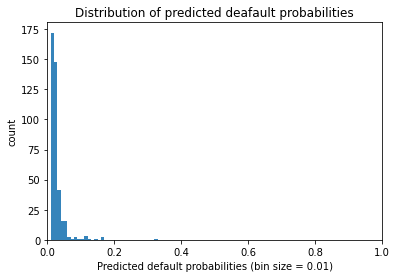

In [14]:
probs1 = rfc1.predict_proba(test_X1)
probs1 = probs1[:, 1]

fig = plt.figure()
# fixed bin size
bins = np.arange(0, 1, 0.01) # fixed bin size
plt.xlim([0, 1])

plt.hist(probs1, bins=bins, alpha=0.9)
plt.title('Distribution of predicted deafault probabilities')
plt.xlabel('Predicted default probabilities (bin size = 0.01)')
plt.ylabel('count')

plt.show()
fig.savefig("plots/model1_predicted_probabilities.png", dpi=fig.dpi, bbox_inches='tight')

# Második modell

SMOTE segítségével kiegyenlítjük a két osztály arányát a tanítóhalmazban

In [15]:
sm = SMOTE(random_state=42)

train_X1_sm, train_y1_sm = sm.fit_resample(train_X1, train_y1)

print(f'''Shape of train_X1 before SMOTE: {train_X1.shape}
Shape of train_X1 after SMOTE: {train_X1_sm.shape}''')

print('\nBalance of positive and negative classes (%):')
train_y1_sm.value_counts(normalize=True) * 100

Shape of train_X1 before SMOTE: (1629, 21)
Shape of train_X1 after SMOTE: (3166, 21)

Balance of positive and negative classes (%):


1    50.0
0    50.0
Name: DEFAULT, dtype: float64

In [16]:
rfc1_sm = RandomForestClassifier(n_estimators=100, random_state=0, max_depth=5, min_samples_leaf=1, max_leaf_nodes=10).fit(train_X1_sm, train_y1_sm)
print("Accuracy: {}".format(rfc1_sm.score(test_X1, test_y1)))

y_pred1_sm = rfc1_sm.predict(test_X1)
print(classification_report(test_y1,y_pred1_sm))
print('Confusion matrix:')
print(confusion_matrix(test_y1, y_pred1_sm))

Accuracy: 0.8063725490196079
              precision    recall  f1-score   support

           0       0.98      0.82      0.89       396
           1       0.08      0.50      0.13        12

    accuracy                           0.81       408
   macro avg       0.53      0.66      0.51       408
weighted avg       0.96      0.81      0.87       408

Confusion matrix:
[[323  73]
 [  6   6]]


Ez a modell már felismerte a nemfizető ügyfelek felét, ugyanakkor a fizetők közel 20%-át is nemfizetőnek jósolta

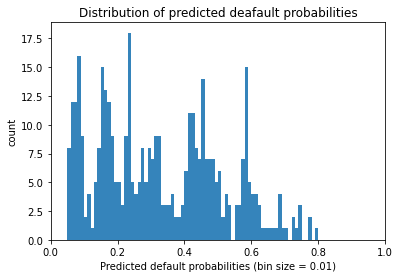

In [17]:
probs1_sm = rfc1_sm.predict_proba(test_X1)
probs1_sm = probs1_sm[:, 1]

fig = plt.figure()
# fixed bin size
bins = np.arange(0, 1, 0.01) # fixed bin size
plt.xlim([0, 1])

plt.hist(probs1_sm, bins=bins, alpha=0.9)
plt.title('Distribution of predicted deafault probabilities')
plt.xlabel('Predicted default probabilities (bin size = 0.01)')
plt.ylabel('count')

plt.show()
fig.savefig("plots/model2_predicted_probabilities.png", dpi=fig.dpi, bbox_inches='tight')

Az egyik döntési fa

[Text(1107.142857142857, 2214.6666666666665, 'MAX_AMT_DELAY_CB <= 0.0\ngini = 0.5\nsamples = 1994\nvalue = [1543, 1623]\nclass = 1'),
 Text(531.4285714285714, 1812.0, 'receivables_per_curr_liab <= 0.063\ngini = 0.265\nsamples = 506\nvalue = [681, 127]\nclass = 0'),
 Text(354.2857142857143, 1409.3333333333333, 'N_OF_APPL_ACCEPTED <= 0.005\ngini = 0.324\nsamples = 374\nvalue = [483, 123]\nclass = 0'),
 Text(177.14285714285714, 1006.6666666666665, 'gini = 0.03\nsamples = 81\nvalue = [128, 2]\nclass = 0'),
 Text(531.4285714285714, 1006.6666666666665, 'gini = 0.379\nsamples = 293\nvalue = [355, 121]\nclass = 0'),
 Text(708.5714285714286, 1409.3333333333333, 'gini = 0.039\nsamples = 132\nvalue = [198, 4]\nclass = 0'),
 Text(1682.857142857143, 1812.0, 'fix_assets_per_liab <= 0.045\ngini = 0.464\nsamples = 1488\nvalue = [862, 1496]\nclass = 1'),
 Text(1240.0, 1409.3333333333333, 'NB_LOANS_PERF <= 0.062\ngini = 0.45\nsamples = 1424\nvalue = [769, 1485]\nclass = 1'),
 Text(885.7142857142857, 100

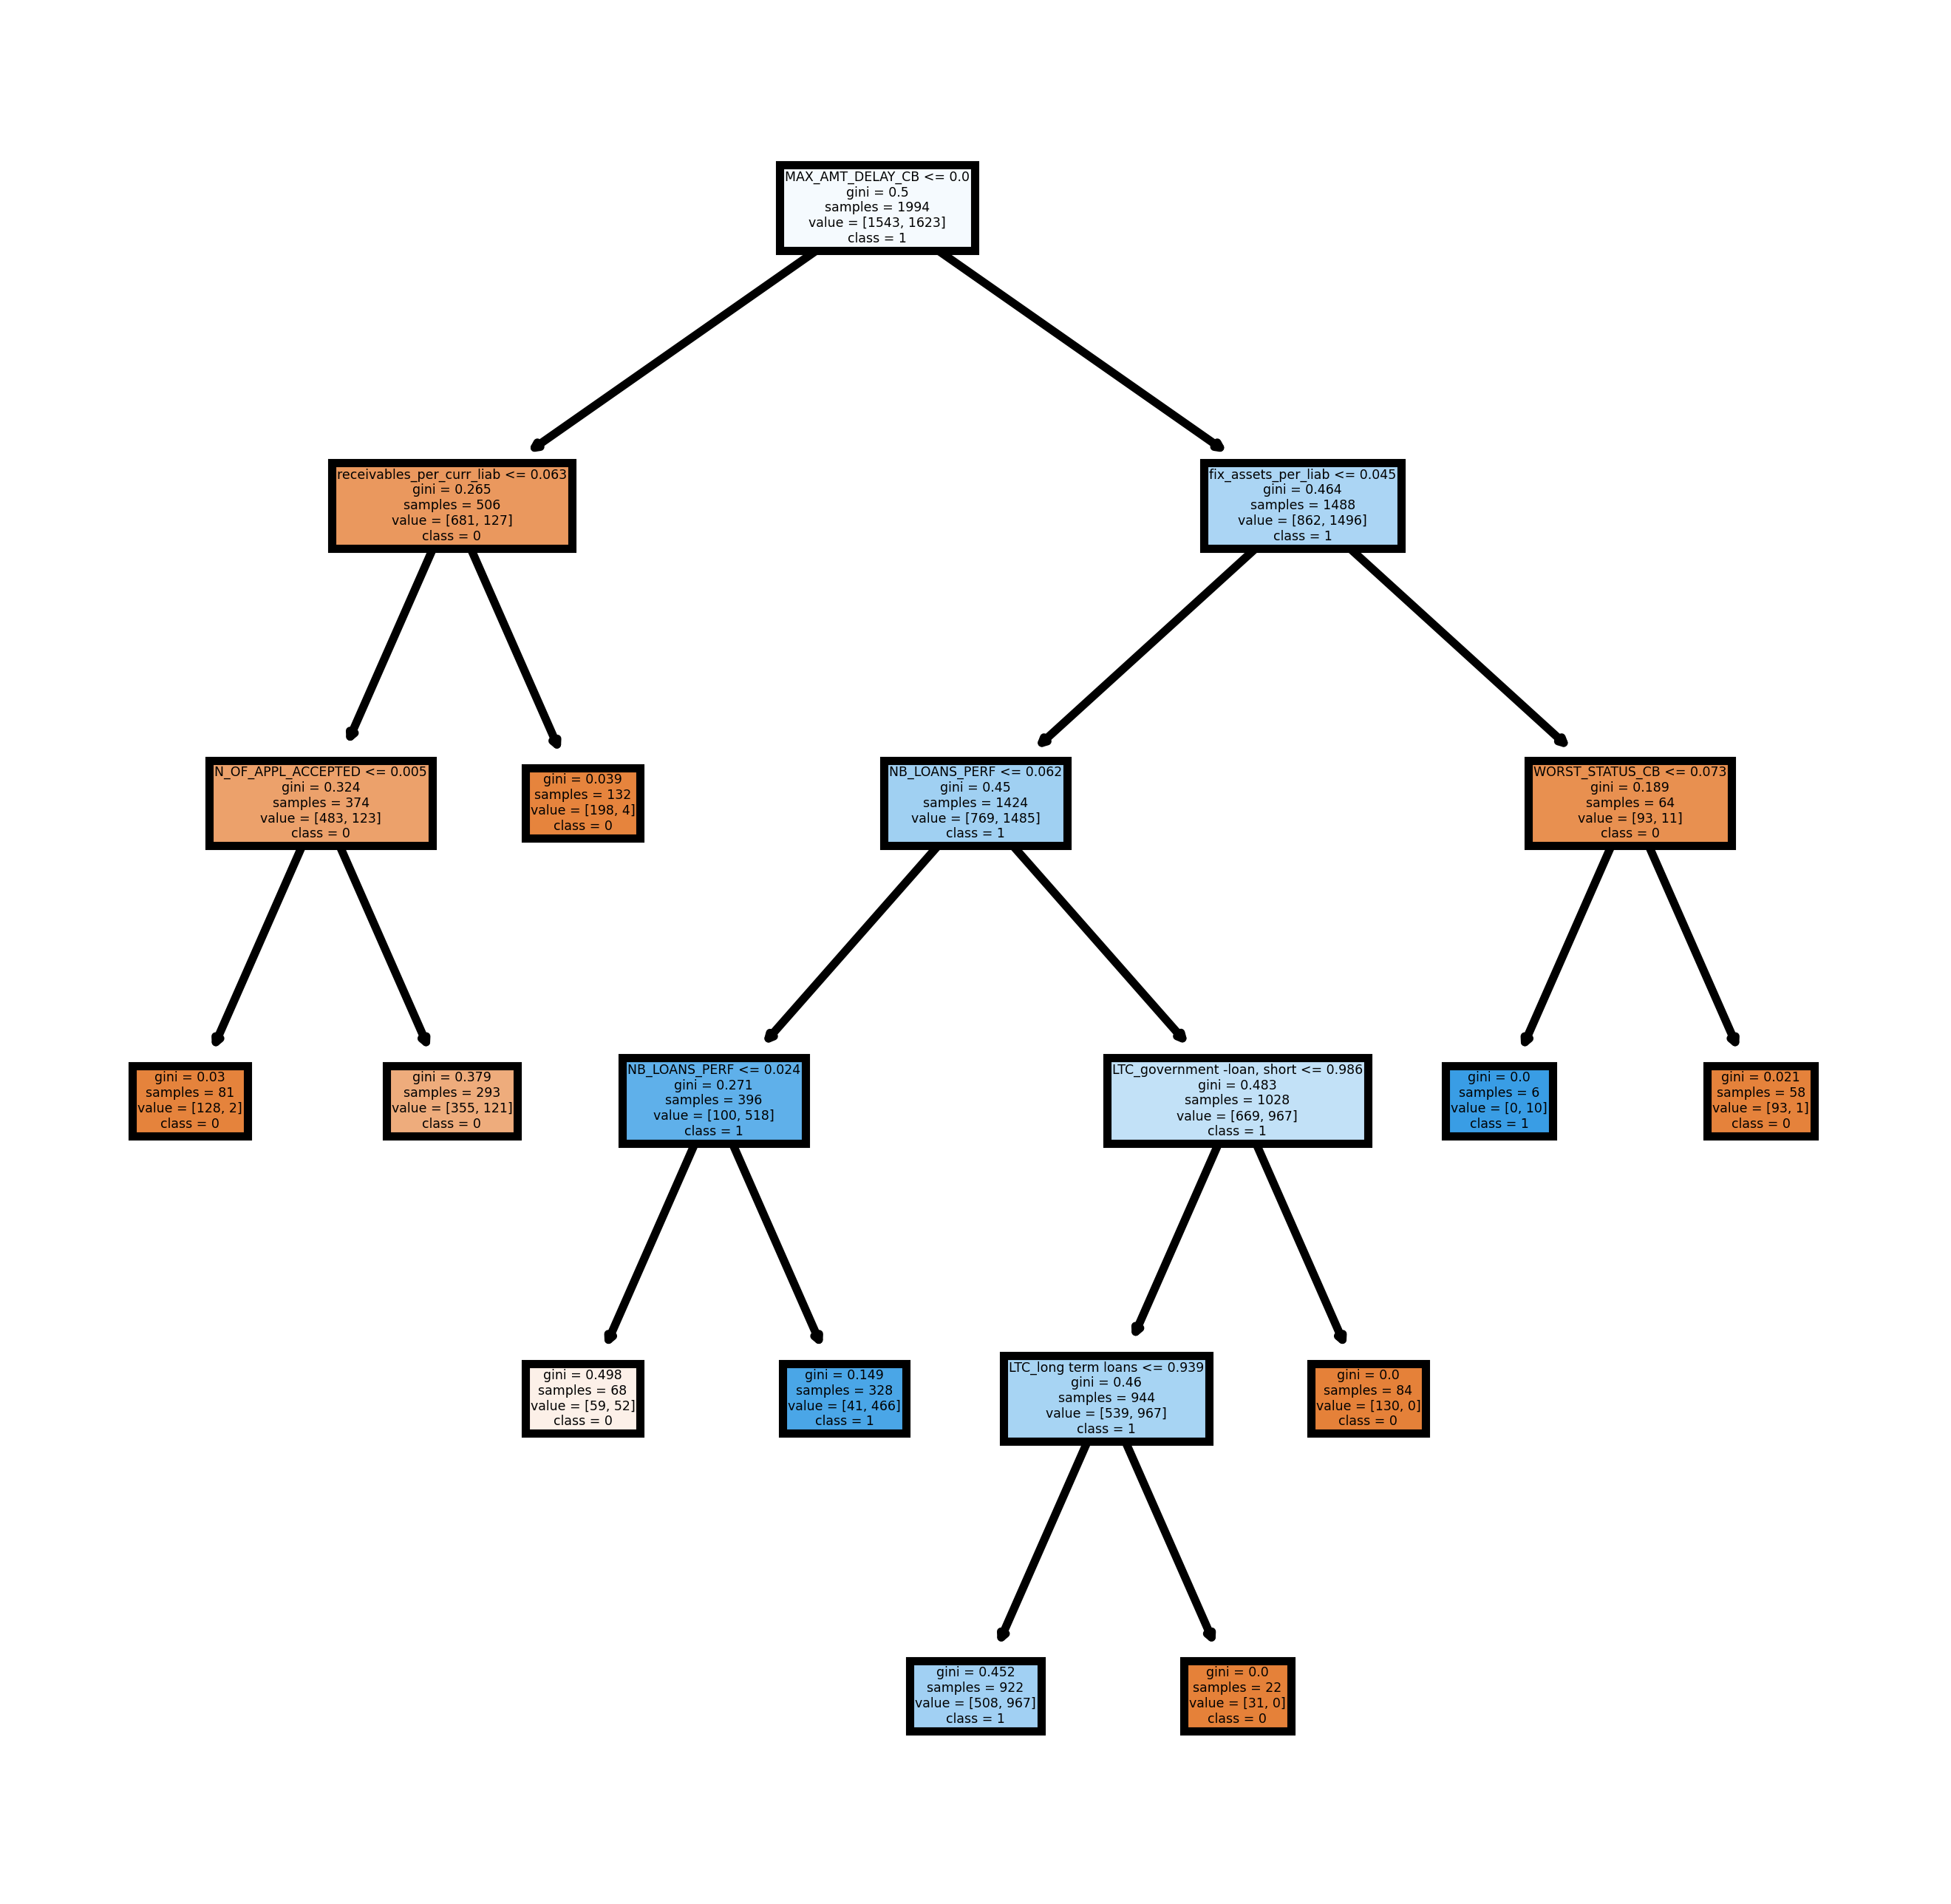

In [18]:
fn = train_X1.columns
cn = rfc1_sm.classes_
fn=[str(x) for x in fn]
cn=[str(x) for x in cn]
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)
tree.plot_tree(rfc1_sm.estimators_[1],
               feature_names = fn, 
               class_names=cn,
               filled = True)

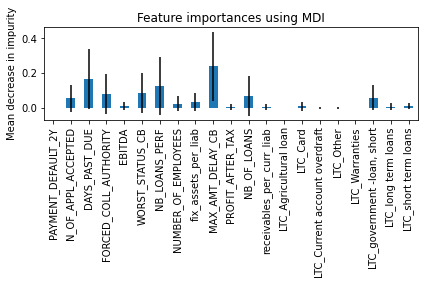

In [19]:
importances = rfc1_sm.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc1_sm.estimators_], axis=0)
forest_importances = pd.Series(importances, index=train_X1.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

# Az első két modell összehasonlítása

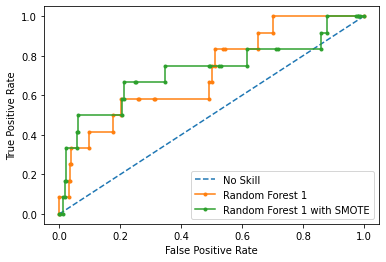

In [20]:
fpr1, tpr1, thresholds1 = roc_curve(test_y1, probs1)
fpr1_sm, tpr1_sm, thresholds1_sm = roc_curve(test_y1, probs1_sm)
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr1, tpr1, marker='.', label='Random Forest 1')
plt.plot(fpr1_sm, tpr1_sm, marker='.', label='Random Forest 1 with SMOTE')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

In [21]:
print(roc_auc_score(test_y1, probs1))
print(roc_auc_score(test_y1, probs1_sm))

0.7133838383838383
0.7241161616161617


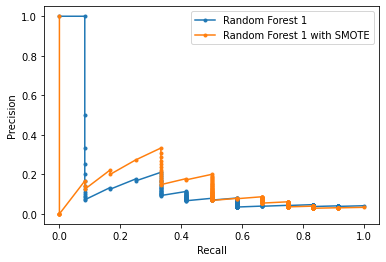

In [22]:
precision1, recall1, thresholds1 = precision_recall_curve(test_y1, probs1)
precision1_sm, recall1_sm, thresholds1_sm = precision_recall_curve(test_y1, probs1_sm)
plt.plot(recall1, precision1, marker='.', label='Random Forest 1')
plt.plot(recall1_sm, precision1_sm, marker='.', label='Random Forest 1 with SMOTE')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
# show the plot
plt.show()

# A magyarázó változók és a célváltozó közötti összefüggés vizsgálata

In [23]:
train_data[train_data['DEFAULT'] == 0].describe()

,CLIENT_ID,DEFAULT,PAYMENT_DEFAULT_2Y,N_OF_APPL_ACCEPTED,DAYS_PAST_DUE,FORCED_COLL_AUTHORITY,EBITDA,WORST_STATUS_CB,NB_LOANS_PERF,NUMBER_OF_EMPLOYEES,fix_assets_per_liab,MAX_AMT_DELAY_CB,PROFIT_AFTER_TAX,NB_OF_LOANS,receivables_per_curr_liab,LTC_Agricultural loan,LTC_Card,LTC_Current account overdraft,LTC_Other,LTC_Warranties,"LTC_government -loan, short",LTC_long term loans,LTC_short term loans
count,1583.000000,1583.0,246.0,1010.000000,995.000000,1358.000000,1.583000e+03,1010.000000,1010.000000,1561.000000,1576.000000,1.010000e+03,1.576000e+03,995.000000,1576.000000,1583.000000,1583.000000,1583.000000,1583.000000,1583.000000,1583.000000,1583.000000,1583.000000
mean,1010.025268,0.0,1.0,10.689109,3.506533,0.307069,3.442868e+06,1.709901,2.524752,219.691224,0.334798,1.230668e+05,1.915342e+06,1.777889,0.422715,0.001263,0.065698,0.217309,0.051800,0.042956,0.108023,0.039798,0.473152
std,589.567637,0.0,0.0,17.264410,34.424190,0.461448,1.576281e+07,0.941290,3.578911,3972.325203,0.820482,9.504118e+05,1.126486e+07,1.098707,0.530464,0.035533,0.247832,0.412545,0.221694,0.202823,0.310507,0.195546,0.499436
min,1.000000,0.0,1.0,0.000000,0.000000,0.000000,-1.048400e+07,1.000000,0.000000,1.000000,0.000000,0.000000e+00,-1.625100e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,500.000000,0.0,1.0,2.000000,0.000000,0.000000,2.645000e+05,1.000000,1.000000,2.000000,0.000000,0.000000e+00,1.347500e+05,1.000000,0.089740,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1008.000000,0.0,1.0,6.000000,0.000000,0.000000,6.560000e+05,2.000000,2.000000,4.000000,0.102964,0.000000e+00,2.870000e+05,1.000000,0.273142,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1518.500000,0.0,1.0,13.000000,0.000000,1.000000,1.940500e+06,2.000000,3.000000,10.000000,0.390539,3.441301e+04,7.500000e+05,2.000000,0.569100,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,2035.000000,0.0,1.0,207.000000,1057.000000,1.000000,2.817260e+08,8.000000,41.000000,90119.000000,21.994444,1.916738e+07,2.360610e+08,7.000000,7.032895,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [24]:
train_data[train_data['DEFAULT'] == 1].describe()

,CLIENT_ID,DEFAULT,PAYMENT_DEFAULT_2Y,N_OF_APPL_ACCEPTED,DAYS_PAST_DUE,FORCED_COLL_AUTHORITY,EBITDA,WORST_STATUS_CB,NB_LOANS_PERF,NUMBER_OF_EMPLOYEES,fix_assets_per_liab,MAX_AMT_DELAY_CB,PROFIT_AFTER_TAX,NB_OF_LOANS,receivables_per_curr_liab,LTC_Agricultural loan,LTC_Card,LTC_Current account overdraft,LTC_Other,LTC_Warranties,"LTC_government -loan, short",LTC_long term loans,LTC_short term loans
count,46.000000,46.0,14.0,26.000000,41.000000,34.000000,4.600000e+01,26.000000,26.000000,44.000000,46.000000,26.000000,4.600000e+01,41.000000,46.000000,46.0,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000
mean,987.152174,1.0,1.0,11.961538,30.707317,0.529412,2.526739e+06,1.807692,3.038462,10.795455,0.186717,113198.461538,1.602304e+06,1.926829,0.360972,0.0,0.021739,0.239130,0.065217,0.043478,0.043478,0.043478,0.543478
std,547.540357,0.0,0.0,9.327297,97.470827,0.506640,5.818660e+06,0.401918,2.199650,18.547964,0.305726,165352.330964,4.256728e+06,1.170262,0.391892,0.0,0.147442,0.431266,0.249637,0.206185,0.206185,0.206185,0.503610
min,14.000000,1.0,1.0,1.000000,0.000000,0.000000,-7.440000e+05,1.000000,0.000000,1.000000,0.000000,0.000000,5.000000e+03,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,527.000000,1.0,1.0,5.000000,0.000000,0.000000,1.870000e+05,2.000000,1.250000,2.000000,0.000000,0.000000,1.242500e+05,1.000000,0.046419,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1050.000000,1.0,1.0,10.500000,0.000000,1.000000,4.490000e+05,2.000000,2.500000,3.000000,0.007081,63888.885000,1.755000e+05,1.000000,0.160263,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1445.500000,1.0,1.0,17.750000,22.000000,1.000000,1.979250e+06,2.000000,4.000000,9.250000,0.220944,156293.210000,5.042500e+05,3.000000,0.675697,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1991.000000,1.0,1.0,33.000000,451.000000,1.000000,2.390800e+07,2.000000,9.000000,97.000000,1.392307,744196.920000,1.838000e+07,5.000000,1.462527,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


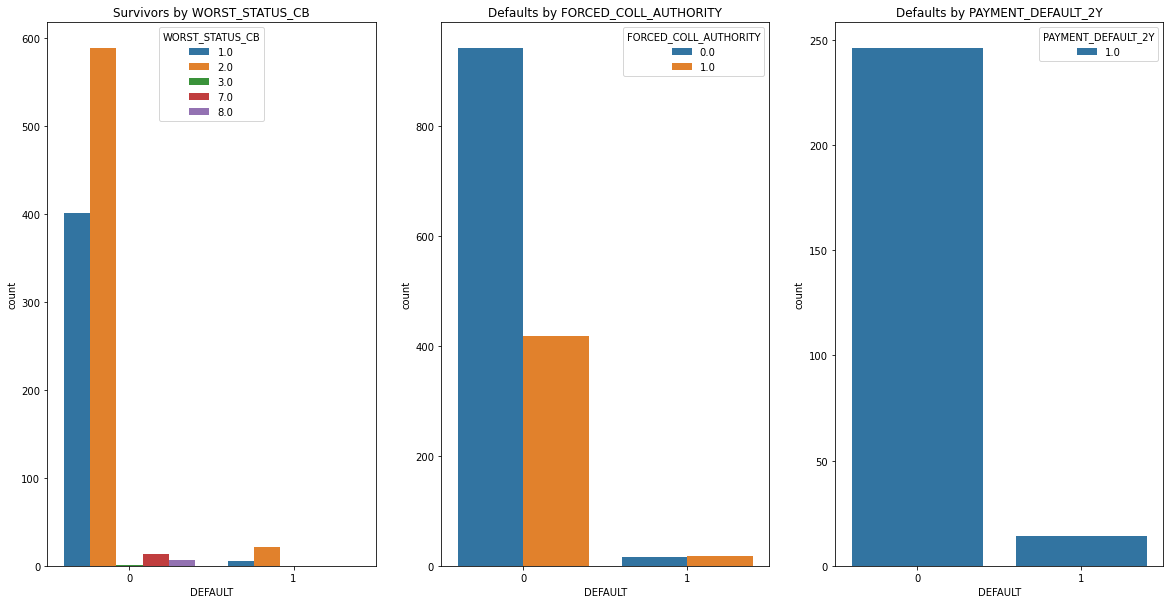

In [25]:
fig, ax = plt.subplots(1, 3, figsize=(20,10))
ax[0].set_title('Survivors by WORST_STATUS_CB')
sns.countplot(x='DEFAULT', hue='WORST_STATUS_CB', data=train_data, ax=ax[0])
ax[1].set_title('Defaults by FORCED_COLL_AUTHORITY')
sns.countplot(x='DEFAULT', hue='FORCED_COLL_AUTHORITY', data=train_data, ax=ax[1])
ax[2].set_title('Defaults by PAYMENT_DEFAULT_2Y')
sns.countplot(x='DEFAULT', hue='PAYMENT_DEFAULT_2Y', data=train_data, ax=ax[2])

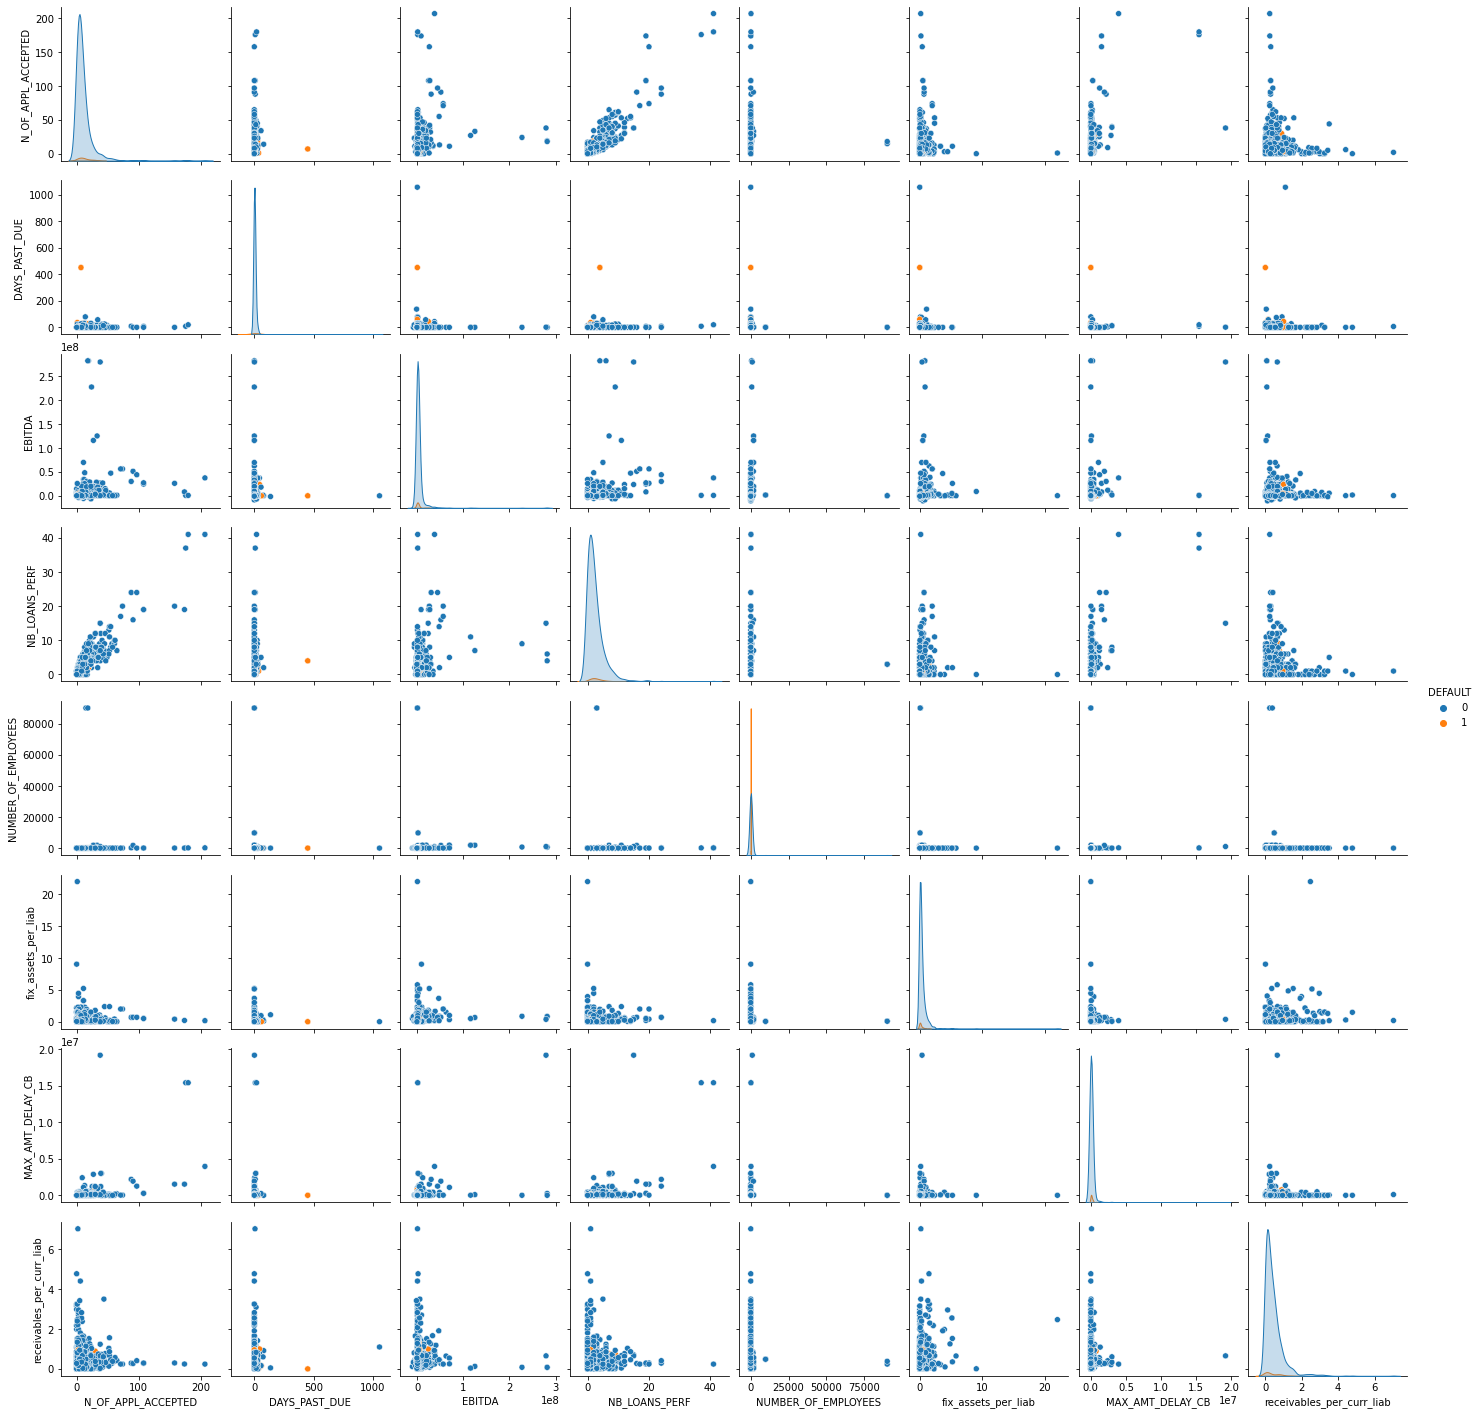

In [26]:
sns.pairplot(train_data[['DEFAULT', 'N_OF_APPL_ACCEPTED', 'DAYS_PAST_DUE', 'EBITDA', 'NB_LOANS_PERF', 'NUMBER_OF_EMPLOYEES', 'fix_assets_per_liab', 'MAX_AMT_DELAY_CB', 'receivables_per_curr_liab']], hue="DEFAULT")

In [27]:
train_data.corr(method='pearson')

,CLIENT_ID,DEFAULT,PAYMENT_DEFAULT_2Y,N_OF_APPL_ACCEPTED,DAYS_PAST_DUE,FORCED_COLL_AUTHORITY,EBITDA,WORST_STATUS_CB,NB_LOANS_PERF,NUMBER_OF_EMPLOYEES,fix_assets_per_liab,MAX_AMT_DELAY_CB,PROFIT_AFTER_TAX,NB_OF_LOANS,receivables_per_curr_liab,LTC_Agricultural loan,LTC_Card,LTC_Current account overdraft,LTC_Other,LTC_Warranties,"LTC_government -loan, short",LTC_long term loans,LTC_short term loans
CLIENT_ID,1.000000,-0.006443,NaN,-0.083923,-0.029065,-0.143771,0.001256,-0.053599,-0.038040,0.008674,0.022367,0.006937,0.007274,0.012441,0.004843,-0.016000,0.041522,-0.049238,0.005819,-0.043271,-0.052828,0.019147,0.061477
DEFAULT,-0.006443,1.000000,NaN,0.011639,0.135490,0.074048,-0.009750,0.016427,0.022639,-0.008710,-0.030329,-0.001645,-0.004672,0.026376,-0.019453,-0.005977,-0.029654,0.008756,0.009994,0.000426,-0.034704,0.003115,0.023328
PAYMENT_DEFAULT_2Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
N_OF_APPL_ACCEPTED,-0.083923,0.011639,NaN,1.000000,0.022800,0.121995,0.203950,0.176936,0.899525,0.021303,0.028636,0.485944,0.165642,0.259757,-0.009977,NaN,-0.030294,-0.066411,0.075981,0.113550,-0.035631,0.003669,-0.001422
DAYS_PAST_DUE,-0.029065,0.135490,NaN,0.022800,1.000000,-0.007519,-0.011759,0.028317,0.043319,-0.007182,-0.034597,0.017559,-0.008086,0.008212,0.013850,0.018597,-0.022970,-0.006596,-0.006576,-0.008032,-0.016502,-0.004432,0.034448
FORCED_COLL_AUTHORITY,-0.143771,0.074048,NaN,0.121995,-0.007519,1.000000,0.048011,0.150490,0.110502,-0.022696,-0.022023,0.115164,0.055430,0.054627,-0.029839,0.015344,-0.033234,-0.015581,0.080505,-0.039750,-0.011899,0.027606,0.001939
EBITDA,0.001256,-0.009750,NaN,0.203950,-0.011759,0.048011,1.000000,0.043332,0.259857,0.009683,0.106832,0.324203,0.959236,0.064997,0.009592,-0.006928,0.020089,-0.067827,-0.006011,0.055317,-0.000741,0.044031,0.010092
WORST_STATUS_CB,-0.053599,0.016427,NaN,0.176936,0.028317,0.150490,0.043332,1.000000,0.175588,-0.021184,0.000214,0.047325,0.036644,0.139268,0.182354,NaN,0.001699,-0.002261,0.008211,0.037106,-0.035034,-0.012219,-0.004092
NB_LOANS_PERF,-0.038040,0.022639,NaN,0.899525,0.043319,0.110502,0.259857,0.175588,1.000000,0.012537,0.031860,0.524203,0.229408,0.380715,-0.029479,NaN,-0.018530,-0.054089,0.057624,0.079290,-0.040972,0.002763,0.005970
NUMBER_OF_EMPLOYEES,0.008674,-0.008710,NaN,0.021303,-0.007182,-0.022696,0.009683,-0.021184,0.012537,1.000000,-0.013485,-0.001452,0.008715,0.044611,-0.010296,-0.001434,-0.013448,0.007567,-0.010692,-0.010380,-0.013479,-0.008505,0.021121


# A hiányzó adatok pótlása IterativeImputer-rel

In [28]:
train_data2 = train_data.copy()
test_data2 = test_data.copy()

imp = IterativeImputer(max_iter=10, random_state=0)
imp.fit(train_data2)

train_data2 = imp.transform(train_data2)
train_data2 = pd.DataFrame(train_data2, columns=train_data.columns)

test_data2 = imp.transform(test_data2)
test_data2 = pd.DataFrame(test_data2, columns=train_data.columns)

train_data2

,CLIENT_ID,DEFAULT,PAYMENT_DEFAULT_2Y,N_OF_APPL_ACCEPTED,DAYS_PAST_DUE,FORCED_COLL_AUTHORITY,EBITDA,WORST_STATUS_CB,NB_LOANS_PERF,NUMBER_OF_EMPLOYEES,fix_assets_per_liab,MAX_AMT_DELAY_CB,PROFIT_AFTER_TAX,NB_OF_LOANS,receivables_per_curr_liab,LTC_Agricultural loan,LTC_Card,LTC_Current account overdraft,LTC_Other,LTC_Warranties,"LTC_government -loan, short",LTC_long term loans,LTC_short term loans
0,1368.0,0.0,1.0,8.575457,0.000000,0.0,233000.0,1.598151,2.528938,5.000000,0.033929,6.539046e+03,0.0,2.000000,0.058261,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1649.0,0.0,1.0,2.000000,0.000000,0.0,643000.0,1.000000,1.000000,4.000000,0.163428,0.000000e+00,340000.0,1.000000,0.257598,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2032.0,0.0,1.0,10.000000,3.706781,0.0,9851000.0,2.000000,3.000000,12.000000,0.478851,9.322053e+04,5311000.0,1.684168,0.950464,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1243.0,0.0,1.0,16.155972,4.085800,0.0,12044000.0,1.492074,4.133300,242.140242,0.064846,1.402427e+06,1153000.0,1.483354,0.071791,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1499.0,0.0,1.0,16.000000,0.000000,0.0,1705000.0,2.000000,6.000000,5.000000,0.374382,0.000000e+00,1099000.0,1.000000,0.715053,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1624,759.0,0.0,1.0,71.000000,4.129875,0.0,56253000.0,2.000000,17.000000,25.000000,1.990251,2.134603e+04,46703000.0,5.001703,0.241523,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1625,688.0,0.0,1.0,8.000000,0.000000,1.0,436000.0,2.000000,1.000000,4.000000,0.007403,2.994186e+04,274000.0,1.000000,0.344248,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1626,400.0,0.0,1.0,0.000000,0.000000,1.0,362000.0,1.000000,0.000000,2.000000,0.056162,0.000000e+00,264000.0,0.000000,0.274961,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1627,1347.0,0.0,1.0,10.577405,4.615102,1.0,830000.0,1.840469,2.464520,30.000000,0.567422,1.214411e+04,448000.0,1.629135,0.442287,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


# Ezúttal csak a leghasznosabbnak tűnő magyarázó változókat használjuk.

In [29]:
train_data2 = train_data2[['DEFAULT', 'DAYS_PAST_DUE', 'NUMBER_OF_EMPLOYEES', 'PROFIT_AFTER_TAX', 'FORCED_COLL_AUTHORITY']]
test_data2 = test_data2[['DEFAULT', 'DAYS_PAST_DUE', 'NUMBER_OF_EMPLOYEES', 'PROFIT_AFTER_TAX', 'FORCED_COLL_AUTHORITY']]
train_data2

,DEFAULT,DAYS_PAST_DUE,NUMBER_OF_EMPLOYEES,PROFIT_AFTER_TAX,FORCED_COLL_AUTHORITY
0,0.0,0.000000,5.000000,0.0,0.0
1,0.0,0.000000,4.000000,340000.0,0.0
2,0.0,3.706781,12.000000,5311000.0,0.0
3,0.0,4.085800,242.140242,1153000.0,0.0
4,0.0,0.000000,5.000000,1099000.0,0.0
...,...,...,...,...,...
1624,0.0,4.129875,25.000000,46703000.0,0.0
1625,0.0,0.000000,4.000000,274000.0,1.0
1626,0.0,0.000000,2.000000,264000.0,1.0
1627,0.0,4.615102,30.000000,448000.0,1.0


# Adatok előkészítése a tanításra

In [30]:
train_y2 = train_data2.DEFAULT
train_X2 = train_data2.drop(['DEFAULT'], axis=1)

test_y2 = test_data2.DEFAULT
test_X2 = test_data2.drop(['DEFAULT'], axis=1)

scaler2 = MinMaxScaler()
scaler2.fit(train_X2)
train_columns2 = train_X2.columns
train_X2 = pd.DataFrame(scaler2.transform(train_X2), columns=train_columns2)
test_X2 = pd.DataFrame(scaler2.transform(test_X2), columns=train_columns2)

train_X2

,DAYS_PAST_DUE,NUMBER_OF_EMPLOYEES,PROFIT_AFTER_TAX,FORCED_COLL_AUTHORITY
0,0.001142,0.000044,0.214416,0.0
1,0.001142,0.000033,0.215548,0.0
2,0.004645,0.000122,0.232091,0.0
3,0.005003,0.002676,0.218253,0.0
4,0.001142,0.000044,0.218074,0.0
...,...,...,...,...
1624,0.005045,0.000266,0.369838,0.0
1625,0.001142,0.000033,0.215328,1.0
1626,0.001142,0.000011,0.215295,1.0
1627,0.005503,0.000322,0.215907,1.0


# Harmadik modell

In [31]:
rfc2 = RandomForestClassifier(n_estimators=100, random_state=0, max_depth=5, min_samples_leaf=1, max_leaf_nodes=10).fit(train_X2, train_y2)
print("Accuracy: {}".format(rfc2.score(test_X2, test_y2)))

y_pred2 = rfc2.predict(test_X2)
print(classification_report(test_y2,y_pred2))
print('Confusion matrix:')
print(confusion_matrix(test_y2, y_pred2))

Accuracy: 0.9730392156862745
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.99       396
         1.0       1.00      0.08      0.15        12

    accuracy                           0.97       408
   macro avg       0.99      0.54      0.57       408
weighted avg       0.97      0.97      0.96       408

Confusion matrix:
[[396   0]
 [ 11   1]]


A harmadik modell által becsült nemfizetési valószínűségek eloszlásának szemléltetése hisztogramon. Az ábra rendkívül hasonlít az első modellhez tartozó hisztogramhoz.

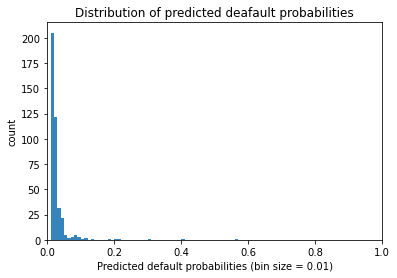

In [32]:
probs2 = rfc2.predict_proba(test_X2)
probs2 = probs2[:, 1]

fig = plt.figure()
# fixed bin size
bins = np.arange(0, 1, 0.01) # fixed bin size
plt.xlim([0, 1])

plt.hist(probs2, bins=bins, alpha=0.9)
plt.title('Distribution of predicted deafault probabilities')
plt.xlabel('Predicted default probabilities (bin size = 0.01)')
plt.ylabel('count')

plt.show()
fig.savefig("plots/model3_predicted_probabilities.png", dpi=fig.dpi, bbox_inches='tight')

# Negyedik modell

In [33]:
sm = SMOTE(random_state=42)

train_X2_sm, train_y2_sm = sm.fit_resample(train_X2, train_y2)

print(f'''Shape of train_X2 before SMOTE: {train_X2.shape}
Shape of train_X2 after SMOTE: {train_X2_sm.shape}''')

print('\nBalance of positive and negative classes (%):')
train_y2_sm.value_counts(normalize=True) * 100

Shape of train_X2 before SMOTE: (1629, 4)
Shape of train_X2 after SMOTE: (3166, 4)

Balance of positive and negative classes (%):


1.0    50.0
0.0    50.0
Name: DEFAULT, dtype: float64

In [34]:
rfc2_sm = RandomForestClassifier(n_estimators=100, random_state=0, max_depth=5, min_samples_leaf=1, max_leaf_nodes=10).fit(train_X2_sm, train_y2_sm)
print("Accuracy: {}".format(rfc2_sm.score(test_X2, test_y2)))

y_pred2_sm = rfc2_sm.predict(test_X2)
print(classification_report(test_y2,y_pred2_sm))
print('Confusion matrix:')
print(confusion_matrix(test_y2, y_pred2_sm))

Accuracy: 0.7965686274509803
              precision    recall  f1-score   support

         0.0       0.99      0.80      0.88       396
         1.0       0.09      0.67      0.16        12

    accuracy                           0.80       408
   macro avg       0.54      0.73      0.52       408
weighted avg       0.96      0.80      0.86       408

Confusion matrix:
[[317  79]
 [  4   8]]


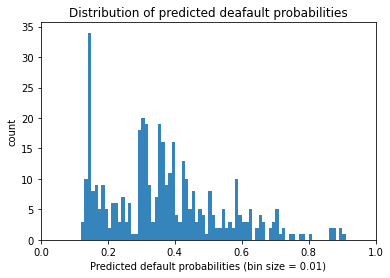

In [35]:
probs2_sm = rfc2_sm.predict_proba(test_X2)
probs2_sm = probs2_sm[:, 1]

fig = plt.figure()
# fixed bin size
bins = np.arange(0, 1, 0.01) # fixed bin size
plt.xlim([0, 1])

plt.hist(probs2_sm, bins=bins, alpha=0.9)
plt.title('Distribution of predicted deafault probabilities')
plt.xlabel('Predicted default probabilities (bin size = 0.01)')
plt.ylabel('count')

plt.show()
fig.savefig("plots/model4_predicted_probabilities.png", dpi=fig.dpi, bbox_inches='tight')

[Text(1573.8461538461538, 2214.6666666666665, 'DAYS_PAST_DUE <= 0.015\ngini = 0.5\nsamples = 1994\nvalue = [1543, 1623]\nclass = 1.0'),
 Text(1049.2307692307693, 1812.0, 'DAYS_PAST_DUE <= 0.005\ngini = 0.492\nsamples = 1658\nvalue = [1483, 1158]\nclass = 0.0'),
 Text(572.3076923076924, 1409.3333333333333, 'PROFIT_AFTER_TAX <= 0.215\ngini = 0.499\nsamples = 1184\nvalue = [884, 981]\nclass = 1.0'),
 Text(381.53846153846155, 1006.6666666666665, 'gini = 0.463\nsamples = 480\nvalue = [270, 472]\nclass = 1.0'),
 Text(763.0769230769231, 1006.6666666666665, 'DAYS_PAST_DUE <= 0.001\ngini = 0.496\nsamples = 704\nvalue = [614, 509]\nclass = 0.0'),
 Text(381.53846153846155, 604.0, 'PROFIT_AFTER_TAX <= 0.216\ngini = 0.473\nsamples = 541\nvalue = [524, 327]\nclass = 0.0'),
 Text(190.76923076923077, 201.33333333333303, 'gini = 0.5\nsamples = 316\nvalue = [252, 241]\nclass = 0.0'),
 Text(572.3076923076924, 201.33333333333303, 'gini = 0.365\nsamples = 225\nvalue = [272, 86]\nclass = 0.0'),
 Text(1144.6

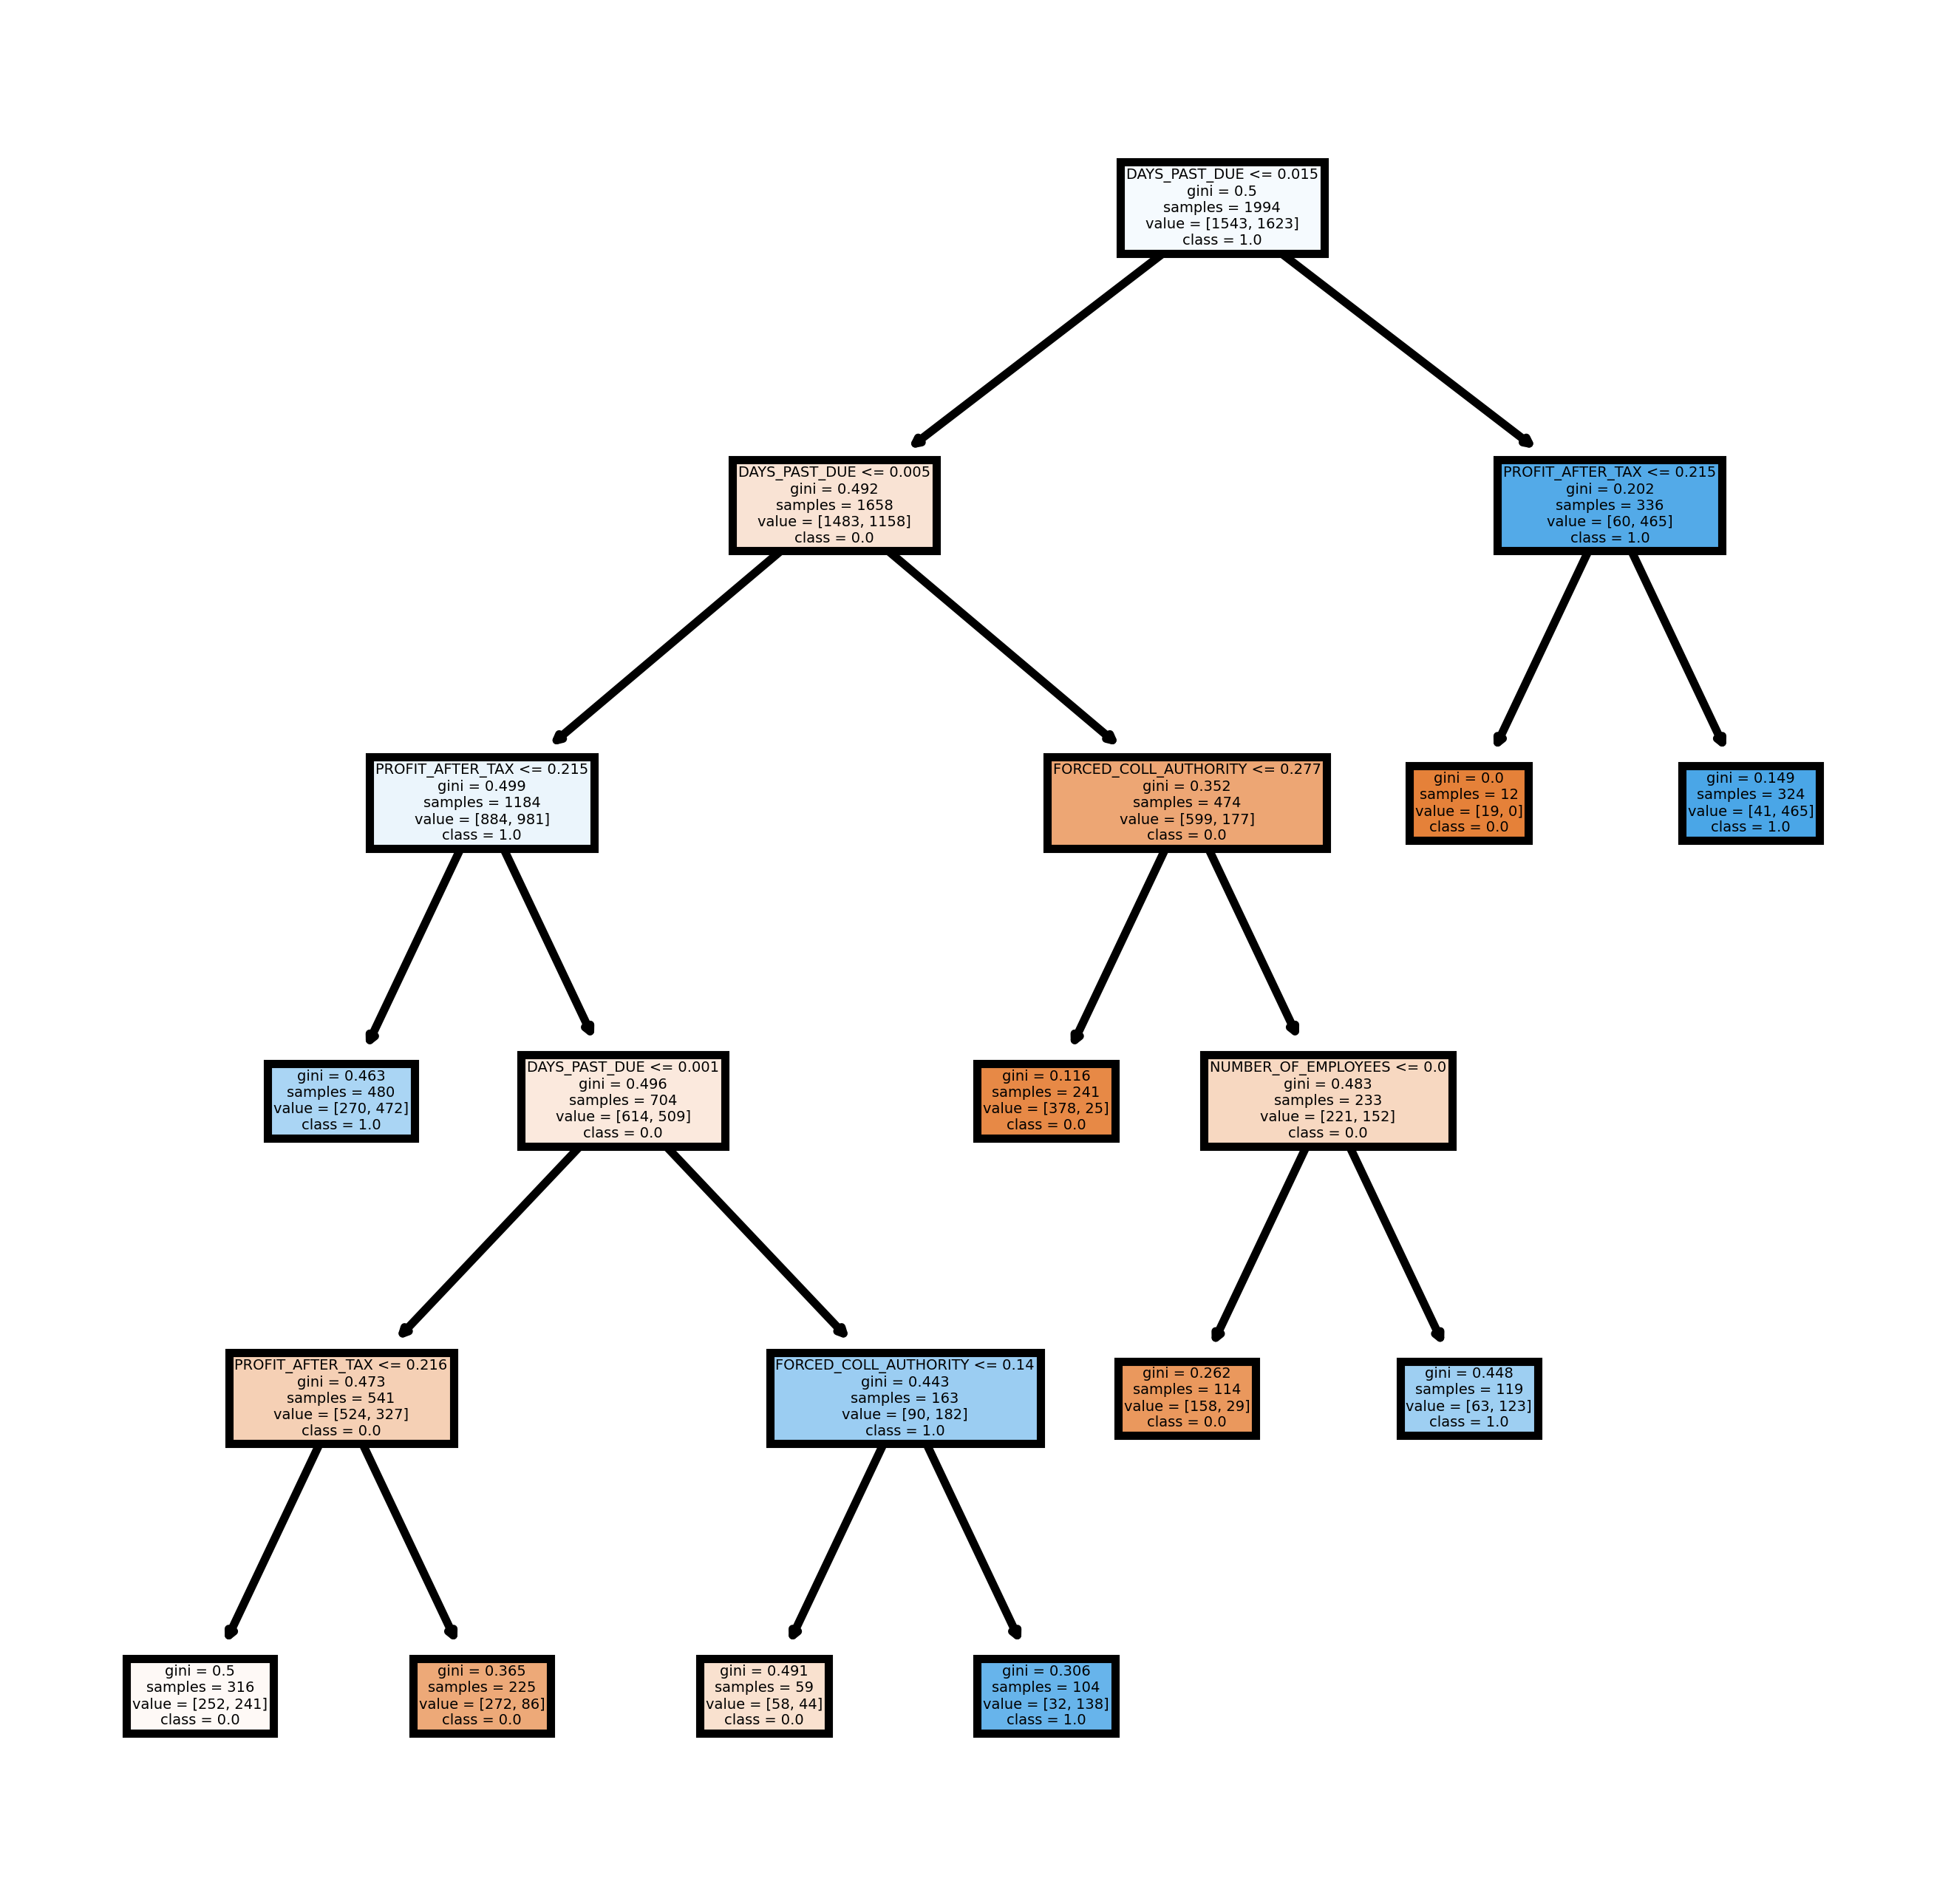

In [36]:
fn = train_X2.columns
cn = rfc2_sm.classes_
fn=[str(x) for x in fn]
cn=[str(x) for x in cn]
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)
tree.plot_tree(rfc2_sm.estimators_[1],
               feature_names = fn, 
               class_names=cn,
               filled = True)

# A négy modell teljesítményének összehasonlítása

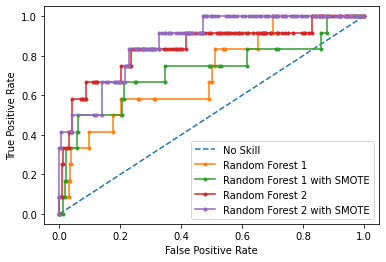

In [37]:
fpr2, tpr2, thresholds2 = roc_curve(test_y2, probs2)
fpr2_sm, tpr2_sm, thresholds2_sm = roc_curve(test_y2, probs2_sm)

# plot the roc curve for the model
fig = plt.figure()

plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr1, tpr1, marker='.', label='Random Forest 1')
plt.plot(fpr1_sm, tpr1_sm, marker='.', label='Random Forest 1 with SMOTE')
plt.plot(fpr2, tpr2, marker='.', label='Random Forest 2')
plt.plot(fpr2_sm, tpr2_sm, marker='.', label='Random Forest 2 with SMOTE')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()
fig.savefig("plots/roc_auc_curves.png", dpi=fig.dpi, bbox_inches='tight')

In [38]:
print("Random Forest 1 ROCAUC-score: ", roc_auc_score(test_y1, probs1))
print("Random Forest 1 with SMOTE ROCAUC-score: ", roc_auc_score(test_y1, probs1_sm))
print("Random Forest 2 ROCAUC-score: ", roc_auc_score(test_y2, probs2))
print("Random Forest 2 with SMOTE ROCAUC-score: ", roc_auc_score(test_y2, probs2_sm))

Random Forest 1 ROCAUC-score:  0.7133838383838383
Random Forest 1 with SMOTE ROCAUC-score:  0.7241161616161617
Random Forest 2 ROCAUC-score:  0.8406986531986532
Random Forest 2 with SMOTE ROCAUC-score:  0.8691077441077442


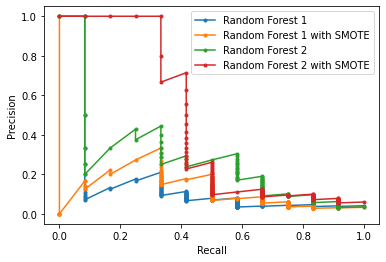

In [39]:
precision2, recall2, thresholds2 = precision_recall_curve(test_y2, probs2)
precision2_sm, recall2_sm, thresholds2_sm = precision_recall_curve(test_y2, probs2_sm)

fig = plt.figure()

plt.plot(recall1, precision1, marker='.', label='Random Forest 1')
plt.plot(recall1_sm, precision1_sm, marker='.', label='Random Forest 1 with SMOTE')
plt.plot(recall2, precision2, marker='.', label='Random Forest 2')
plt.plot(recall2_sm, precision2_sm, marker='.', label='Random Forest 2 with SMOTE')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
# show the plot
plt.show()
fig.savefig("plots/precision_recall_curves.png", dpi=fig.dpi, bbox_inches='tight')